In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torchvision
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
class PrepNetwork(nn.Module):
    def __init__(self):
        super(PrepNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=5,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=5,out_channels=3,kernel_size=(3,3),stride=1,padding=1)
       
    def forward(self,secret_image):
        
        output_1 = F.relu(self.conv1(secret_image))
        output_2 = F.relu(self.conv2(output_1))

        return output_2

In [3]:
class HidingNetwork(nn.Module):
    def __init__(self):
        super(HidingNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=6,out_channels=5,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=5,out_channels=3,kernel_size=(3,3),stride=1,padding=1)
    def forward(self,cover_image,secret_image):
        
#         print(cover_image.shape,secret_image.shape)
#         secret_image =  secret_image.permute(1, 2, 0)
        concate_input = torch.cat([cover_image,secret_image],dim=0)
#         print(concate_input.shape)
        output_1 = F.relu(self.conv1(concate_input))
        output_2 = F.relu(self.conv2(output_1))
        return output_2  

In [4]:
class Encoder(nn.Module):
    def __init__(self,prep_network,hiding_network):
        super(Encoder, self).__init__()
        self.prep_network = prep_network
        self.hiding_network = hiding_network
    
    def forward(self,cover_image,secret_image):
        
        encoded_secret_image = self.prep_network(secret_image)
        hidden_image = self.hiding_network(cover_image,encoded_secret_image)
        return hidden_image

In [5]:
prep_net = PrepNetwork()
hiding_net = HidingNetwork()

encoder = Encoder(prep_net,hiding_net)

loss_func = nn.MSELoss()

optimizer = optim.Adam(encoder.parameters(), lr=0.001)

In [6]:
dataset_path = './tiny-imagenet-200'
training_folder_dir = './tiny-imagenet-200/train'
train_csv = 'train_dataset.csv'
training_csv_path = './'+train_csv
df = pd.read_csv(training_csv_path).reset_index(drop=True)
IMG_SIZE =128

transformation = torchvision.transforms.Compose([torchvision.transforms.Resize((IMG_SIZE,IMG_SIZE)),torchvision.transforms.ToTensor()])
data_train = []

for index, row in df.iterrows():
    cover_image = Image.open(dataset_path+'/train'+'/images/'+row['cover_image'])
    secret_image = Image.open(dataset_path+'/train'+'/images/'+row['secret_image_1'])
    
    transformed_cover_image = transformation(cover_image)
    transformed_secret_image = transformation(secret_image)
    
    data = {
                'cover_image':transformed_cover_image,
                'secret_image':transformed_secret_image
            }
    
    data_train.append(data)
    

In [7]:
EPOCHS = 5

for epoch in range(EPOCHS):
    for data in data_train:
#         print(data['cover_image'].shape)
        data['cover_image'] = data['cover_image'].expand(3, -1, -1)
        data['secret_image'] = data['secret_image'].expand(3, -1, -1)
        hidden_img = encoder(data['cover_image'],data['secret_image'])
        actual_output = data['cover_image'] + 0.1 * torch.randn_like(data['cover_image'])
        loss = loss_func(hidden_img, actual_output)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

In [8]:
hidden_img_dataset = []

for data in data_train:
    data['cover_image'] = data['cover_image'].expand(3, -1, -1)
    data['secret_image'] = data['secret_image'].expand(3, -1, -1)
    hidden_img = encoder(data['cover_image'],data['secret_image'])
    output = {
        'hidden_image' : hidden_img,
        'secret_image' : data['secret_image'],
        'cover_image' : data['cover_image']
    }
    hidden_img_dataset.append(output)

In [9]:
i = 20
predicted_op = encoder(transformation(Image.open(dataset_path+'/train'+'/images/'+df.at[i, 'cover_image'])),transformation(Image.open(dataset_path+'/train'+'/images/'+df.at[i,'secret_image_1'])))

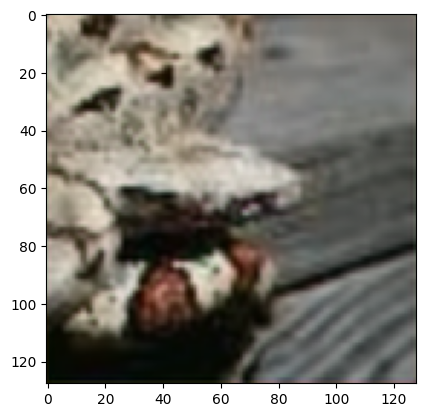

In [10]:
predicted_op= (predicted_op.permute(1,2,0))*255
plt.imshow(predicted_op.int().detach().numpy())

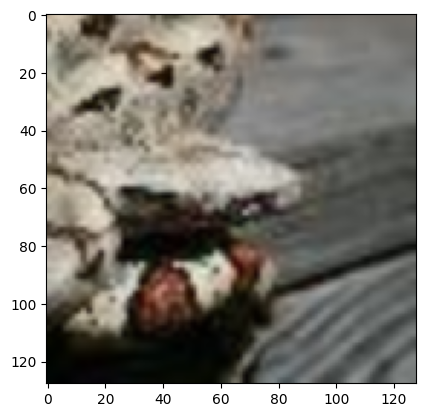

In [11]:
plt.imshow(transformation(Image.open(dataset_path+'/train'+'/images/'+df.at[i, 'cover_image'])).permute(1,2,0))

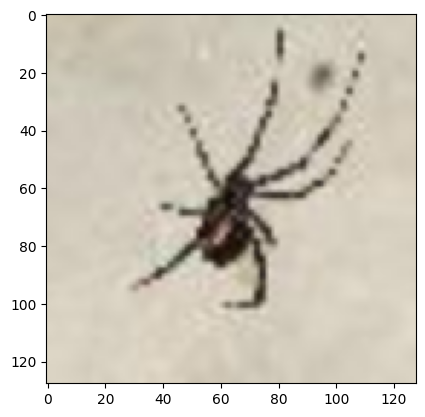

In [12]:
plt.imshow(transformation(Image.open(dataset_path+'/train'+'/images/'+df.at[i, 'secret_image_1'])).permute(1,2,0))

In [13]:
class RevealNetwork(nn.Module):
    def __init__(self):
        super(RevealNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=5,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=5,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=10,out_channels=3,kernel_size=(3,3),stride=1,padding=1)
    def forward(self,secret_image):
        output_1 = F.relu(self.conv1(secret_image))
        output_2 = F.relu(self.conv2(output_1))
        output_3 = F.relu(self.conv3(output_2))
        return output_3

In [30]:
class Decoder(nn.Module):
    def __init__(self,reveal_network):
        super(Decoder, self).__init__()
        self.reveal_network = reveal_network
    
    def forward(self,hidden_image):
        decoded_secret_image = self.reveal_network(hidden_image)
        return decoded_secret_image

In [44]:
reveal_net = RevealNetwork()

decoder = Decoder(reveal_net)

loss_func_decoder = nn.MSELoss()

optimizer_decoder = optim.Adam(decoder.parameters(), lr=0.001)

In [56]:
EPOCHS = 10
from torch.autograd import Variable as V

for epoch in range(EPOCHS):
    for data in hidden_img_dataset:
#         transform_ = torchvision.transforms.ToPILImage()
        secret_img_predicted = V(decoder(data['hidden_image']))
        loss_ = loss_func_decoder(secret_img_predicted,data['secret_image'])
        loss_ = V(loss_, requires_grad = True)
        optimizer_decoder.zero_grad()
        loss_.backward(retain_graph=True)
        optimizer_decoder.step()

In [99]:
i = 2
predicted_op = decoder((hidden_img_dataset[i]['hidden_image']))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


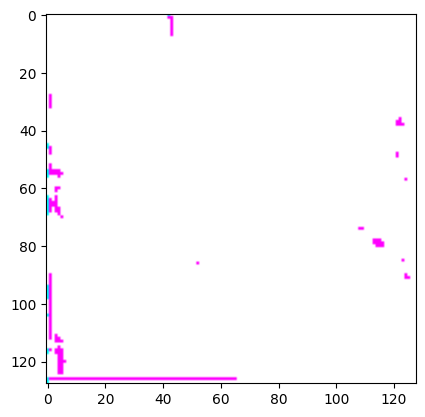

In [110]:
predicted_op= (predicted_op.permute(1,2,0))*255
plt.imshow(predicted_op.int().detach().numpy())

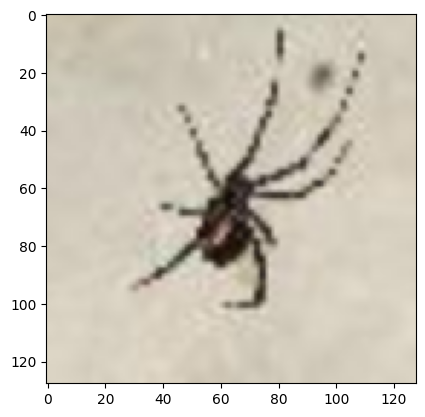

In [59]:
plt.imshow(hidden_img_dataset[i]['secret_image'].permute(1,2,0))